# fiabilipym — Monte Carlo Reliability Demo with Weibull Aging

This notebook demonstrates the **extended fiabilipym package** with full support for:

- Series system (3 components)
- Parallel system (3 components)
- Series–Parallel system (3 stages)
- Parallel–Series system (3 branches)
- Voting system (2-out-of-3)

All results are computed using **Monte Carlo simulation with Weibull aging**.

For each architecture we compute:
- **MTTF** (mean time to failure)
- **Reliability curves** \(R(t)\)

And we visualize:
- MTTF bar plot (per architecture)
- Reliability curves \(R(t)\)
- MTTF vs baseline \(\lambda\) (mean-matched sweep)

This notebook assumes the updated **fiabilipym** API:
- `Component.with_distribution(...)`
- `Weibull(beta, eta)`
- `System.monte_carlo(...)`
- `Voter.monte_carlo(...)`


## 0) Imports and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fiabilipym import Component, System, Voter
from fiabilipym.distribution import Weibull, weibull_eta_from_lambda

# reproducibility
rng_seed = 42


## 1) Weibull aging parameters

We use:
- Weibull shape \(\beta > 1\) → aging / wear-out
- A baseline \(\lambda\) that is **mean-matched** to the Weibull scale

This keeps the traditional \(1/\lambda\) intuition while allowing non-exponential aging.


In [2]:
beta = 2.0          # Weibull shape (aging)
lam0 = 1e-4         # baseline lambda (mean-matched)
eta0 = weibull_eta_from_lambda(lam0, beta)

n_mc = 50_000       # Monte Carlo trials
t_max = 3.0 / lam0  # time horizon
T = np.linspace(0, t_max, 250)

print(f"beta = {beta}")
print(f"lambda = {lam0}")
print(f"eta (mean-matched) = {eta0:.6g}")


beta = 2.0
lambda = 0.0001
eta (mean-matched) = 11283.8


## 2) Helper: build Weibull-aging components

We attach Weibull lifetime distributions to each component via `with_distribution(...)`.

> If you implemented a different mechanism (e.g., `AgingComponent` subclass), adapt this function.


In [3]:
def aging_component(name: str, lam_baseline: float, beta: float, eta: float, age0: float = 0.0) -> Component:
    # lam_baseline is kept for backwards-compatibility / metadata; Monte Carlo uses the distribution.
    c = Component(name, lam_baseline)
    c.with_distribution(Weibull(beta=beta, eta=eta), age0=age0)
    return c


## 3) Build the 5 architectures (fiabilipym backbone)

We keep the exact style from classic fiabilipy/fiabilipym:
- Use `"E"` and `"S"` as entry/exit sentinel nodes
- Use intermediate string nodes like `"N1"`, `"N2"` where convenient


In [4]:
def build_series3(lam: float, beta: float, eta: float) -> System:
    c1 = aging_component("C1", lam, beta, eta)
    c2 = aging_component("C2", lam, beta, eta)
    c3 = aging_component("C3", lam, beta, eta)

    S = System()
    S["E"] = [c1]
    S[c1] = [c2]
    S[c2] = [c3]
    S[c3] = "S"
    return S

def build_parallel3(lam: float, beta: float, eta: float) -> System:
    c1 = aging_component("C1", lam, beta, eta)
    c2 = aging_component("C2", lam, beta, eta)
    c3 = aging_component("C3", lam, beta, eta)

    S = System()
    S["E"] = [c1, c2, c3]
    S[c1] = "S"
    S[c2] = "S"
    S[c3] = "S"
    return S

def build_series_parallel_3stages(lam: float, beta: float, eta: float) -> System:
    # (A1 || A2) -- (B1 || B2) -- (C1 || C2)
    A1 = aging_component("A1", lam, beta, eta)
    A2 = aging_component("A2", lam, beta, eta)
    B1 = aging_component("B1", lam, beta, eta)
    B2 = aging_component("B2", lam, beta, eta)
    C1 = aging_component("C1", lam, beta, eta)
    C2 = aging_component("C2", lam, beta, eta)

    S = System()
    S["E"] = [A1, A2]
    S[A1] = "N1"
    S[A2] = "N1"

    S["N1"] = [B1, B2]
    S[B1] = "N2"
    S[B2] = "N2"

    S["N2"] = [C1, C2]
    S[C1] = "S"
    S[C2] = "S"
    return S

def build_parallel_series_3branches(lam: float, beta: float, eta: float) -> System:
    # (A1--A2) || (B1--B2) || (C1--C2)
    A1 = aging_component("A1", lam, beta, eta)
    A2 = aging_component("A2", lam, beta, eta)
    B1 = aging_component("B1", lam, beta, eta)
    B2 = aging_component("B2", lam, beta, eta)
    C1 = aging_component("C1", lam, beta, eta)
    C2 = aging_component("C2", lam, beta, eta)

    S = System()
    S["E"] = [A1, B1, C1]

    S[A1] = [A2]
    S[A2] = "S"

    S[B1] = [B2]
    S[B2] = "S"

    S[C1] = [C2]
    S[C2] = "S"
    return S

def build_voter_2of3(lam: float, beta: float, eta: float):
    if Voter is None:
        raise ImportError("Voter is not available in this fiabilipym install.")

    # common signature: Voter(k, [components])
    base = aging_component("C", lam, beta, eta)

    # Voter expects a base component and M,N values
    return Voter(base, M=2, N=3)

ARCH_BUILDERS = {
    "Series (3)": build_series3,
    "Parallel (3)": build_parallel3,
    "Series–Parallel (3 stages)": build_series_parallel_3stages,
    "Parallel–Series (3 branches)": build_parallel_series_3branches,
    "Voter 2-out-of-3": build_voter_2of3,
}


## 4) Run Monte Carlo: MTTF + reliability curves

We use:
- `System.monte_carlo(n, grid_t, seed=..., return_samples=False)`
- `Voter.monte_carlo(...)`

and collect results for plotting.


In [5]:
objects = {}
mttf = {}
R_curves = {}
errors = {}

for name, builder in ARCH_BUILDERS.items():
    try:
        obj = builder(lam0, beta, eta0)
        objects[name] = obj

        # unified call: both System and Voter implement monte_carlo(...)
        out = obj.monte_carlo(n=n_mc, grid_t=T, seed=rng_seed, return_samples=False)
        # allow either (mttf, R) or dict-like
        if isinstance(out, tuple) and len(out) >= 2:
            mttf[name] = float(out[0])
            R_curves[name] = np.asarray(out[1], dtype=float)
        elif isinstance(out, dict):
            mttf[name] = float(out["mttf"])
            R_curves[name] = np.asarray(out["R"], dtype=float)
        else:
            raise TypeError(f"Unexpected monte_carlo() return type: {type(out)}")

    except Exception as e:
        errors[name] = str(e)

print("Computed architectures:", list(mttf.keys()))
if errors:
    print("\nSkipped architectures due to errors:")
    for k, v in errors.items():
        print(f"  - {k}: {v}")


Computed architectures: ['Series (3)', 'Parallel (3)', 'Series–Parallel (3 stages)', 'Parallel–Series (3 branches)', 'Voter 2-out-of-3']


## 5) MTTF summary table

In [6]:
try:
    import pandas as pd
except ImportError:
    pd = None

rows = [{"Architecture": k, "MTTF (MC)": v} for k, v in mttf.items()]
if pd is None:
    rows
else:
    df = pd.DataFrame(rows).sort_values("Architecture").reset_index(drop=True)
    df


## 6) Plot: MTTF bar chart

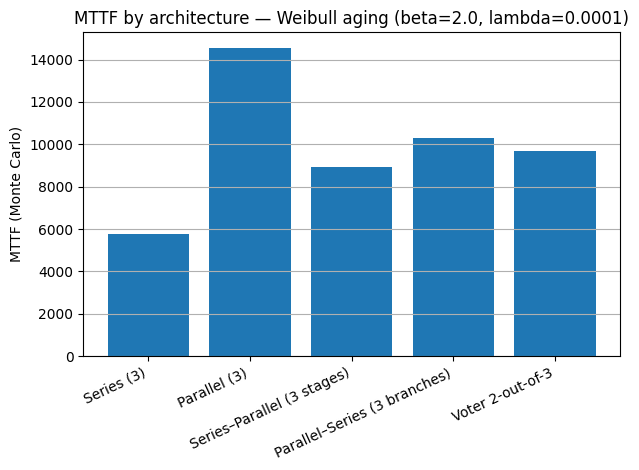

In [7]:
labels = list(mttf.keys())
vals = [mttf[k] for k in labels]

if not mttf:
    raise RuntimeError("No MTTF data computed. Check errors above.")

plt.figure()
plt.bar(labels, vals)
plt.ylabel("MTTF (Monte Carlo)")
plt.title(f"MTTF by architecture — Weibull aging (beta={beta}, lambda={lam0:g})")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 7) Plot: Reliability curves \(R(t)\)

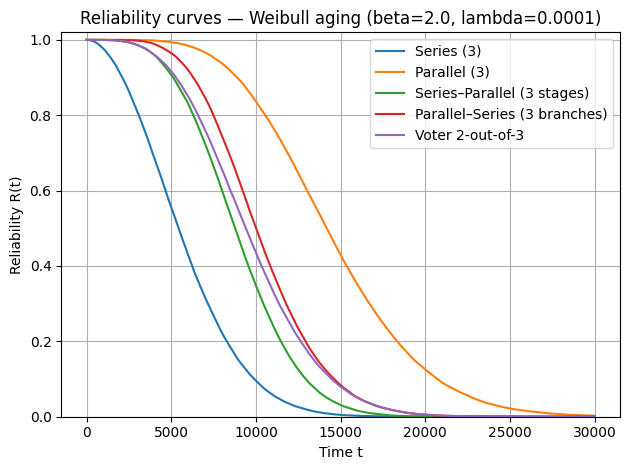

In [8]:
if not R_curves:
    raise RuntimeError("No R(t) curves computed. Check errors above.")

plt.figure()
for name, R in R_curves.items():
    plt.plot(T, R, label=name)

plt.xlabel("Time t")
plt.ylabel("Reliability R(t)")
plt.ylim(0, 1.02)
plt.title(f"Reliability curves — Weibull aging (beta={beta}, lambda={lam0:g})")
plt.grid(True)
if R_curves:
    plt.legend()
plt.tight_layout()
plt.show()


## 8) Optional: MTTF vs baseline \(\lambda\) sweep

We vary baseline \(\lambda\), mean-match Weibull \(\eta\), and recompute MTTF.

This illustrates how architecture interacts with overall component strength scale.


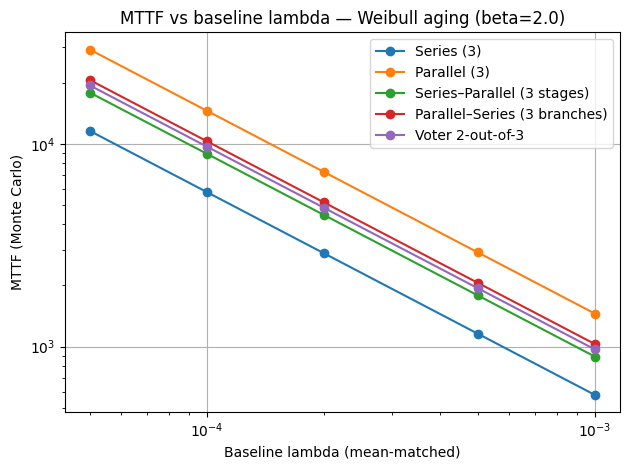

In [9]:
lams = np.array([5e-5, 1e-4, 2e-4, 5e-4, 1e-3], dtype=float)

plt.figure()
for name, builder in ARCH_BUILDERS.items():
    if name in errors:
        continue
    y = []
    for lam in lams:
        eta = weibull_eta_from_lambda(float(lam), beta)
        obj = builder(float(lam), beta, eta)
        out = obj.monte_carlo(n=20_000, grid_t=np.array([0.0]), seed=rng_seed, return_samples=False)
        m = float(out[0]) if isinstance(out, tuple) else float(out["mttf"])
        y.append(m)

    plt.plot(lams, y, marker="o", label=name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Baseline lambda (mean-matched)")
plt.ylabel("MTTF (Monte Carlo)")
plt.title(f"MTTF vs baseline lambda — Weibull aging (beta={beta})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 9) Optional: Draw system graphs

If your `fiabilipym.System.draw()` is set up (Graphviz/pygraphviz), you can render the diagrams.

Skip if not available in your environment.


Drawing: Series (3)


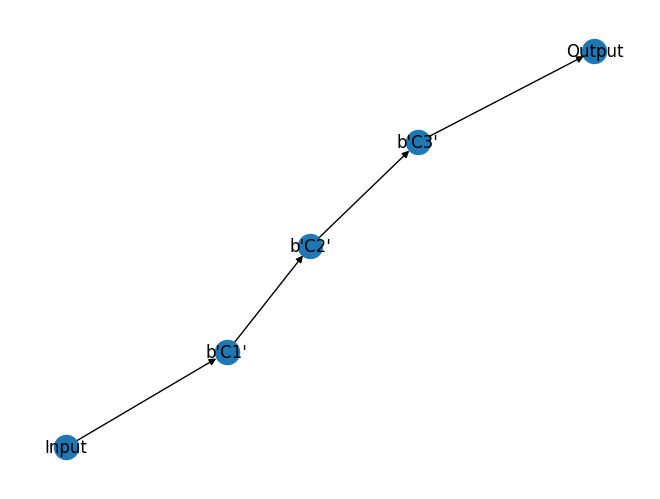

Drawing: Parallel (3)


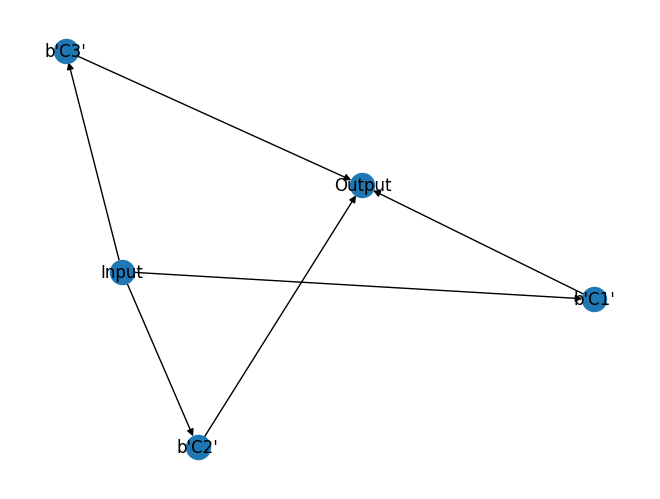

Drawing: Series–Parallel (3 stages)


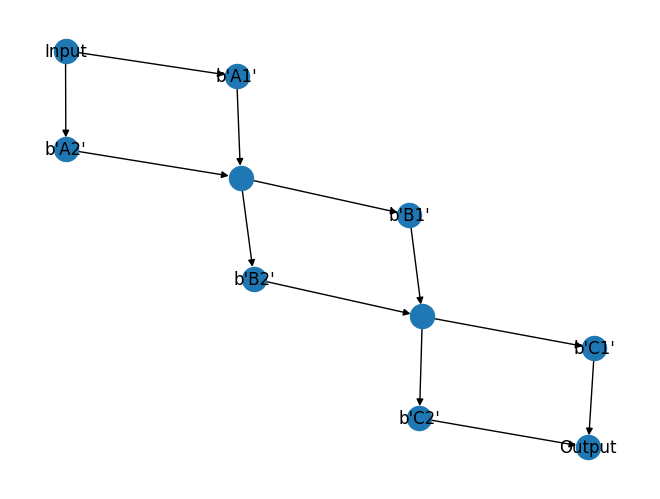

Drawing: Parallel–Series (3 branches)


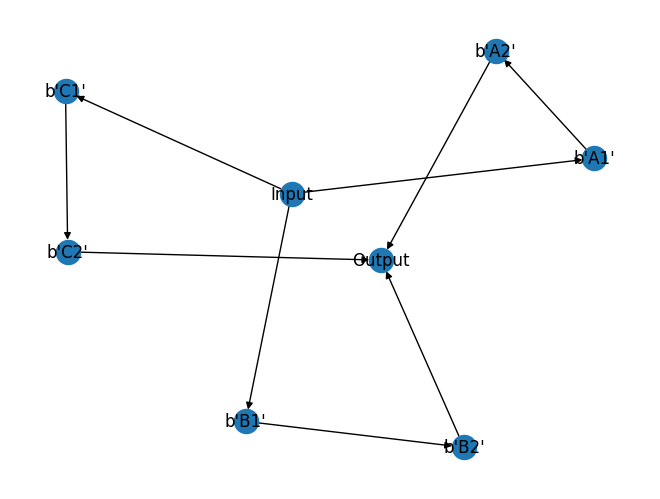

Drawing: Voter 2-out-of-3


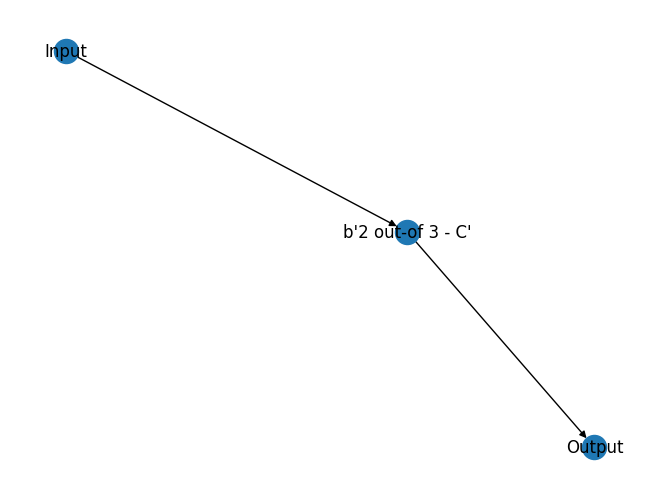

In [10]:
for name, obj in objects.items():
    print(f"Drawing: {name}")
    try:
        if not hasattr(obj, "draw"):
            print("  draw() not available for this object")
            continue
        obj.draw()
        plt.show()
    except Exception as e:
        print(f"  could not draw: {e}")
